In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 

import matplotlib.pyplot as plt #pip install matplotlib
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')
font = font_manager.FontProperties(family='serif', size=16)

import numpy as np
import math, os, random
from einops import rearrange #pip install einops
from typing import List

from pathlib import Path
from PIL import Image

import tqdm
from tqdm.notebook import tqdm #pip install tqdm

import pickle



import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os
import random

# --- Add this block to your script ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using Apple's Metal Performance Shaders.")
else:
    device = torch.device("cpu")
    print("No GPU available. Using CPU.")
# ---

wandb.login(key="285708147e02543770d8ac9dde1c5d1c658d750f")  


CUDA is available. Using GPU.


# Load the Flamingo data:
The data shape is (5000, 4, 100, 100)
Each channel corresponds to a different quantity: 0-total mass, 1 - X-rays, 2- stellar mass/particles

In [2]:
with open('./data/flamingo.pkl', 'rb') as file:
    labels, images = pickle.load(file)

(5000, 4, 100, 100)


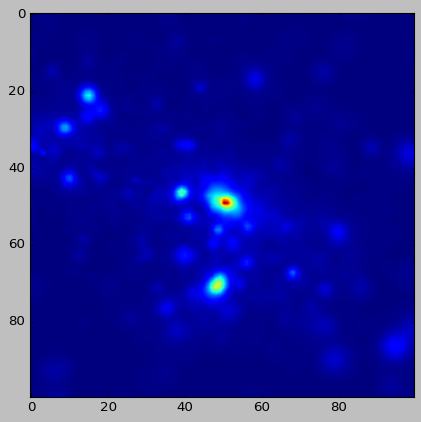

In [3]:
plt.imshow(images[0][3])
print(images.shape)

# Diffusion models for Galaxy images generation
______________
# Part 1: Designing the generative model

## Model design
Code source from <a href="https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946" target="_blank">Diffusion Model from Scratch in Pytorch</a> 

### UNET model
For our diffusion model we consider a architecture based on the <a href="https://arxiv.org/pdf/1505.04597" target="_blank"> UNET</a> model.

"The main idea is to supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators. Hence, these layers increase the resolution of the output. In order to localize, high resolution features from the contracting path are combined with the upsampled output. A successive convolution layer can then learn to assemble a more precise output based on this information"

*from "U-Net: Convolutional Networks for Biomedical Image Segmentation" (https://arxiv.org/pdf/1505.04597)*

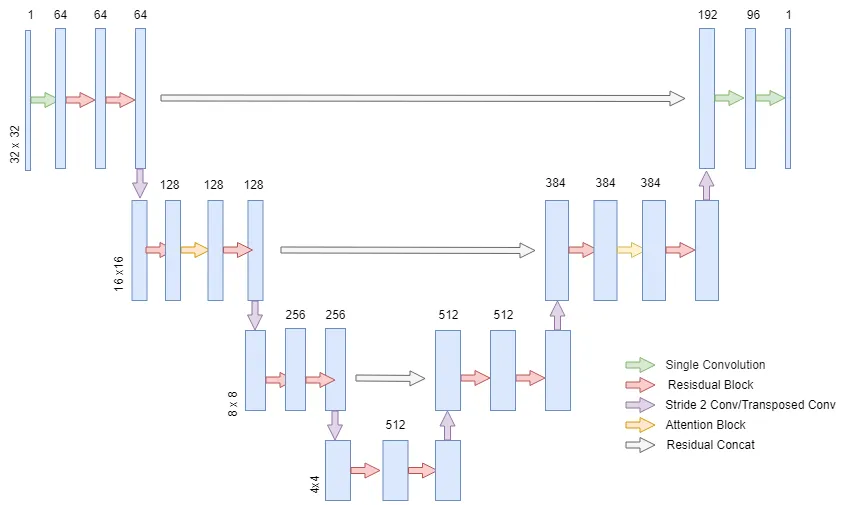

*by Nicholas DiSalvo in* <a href="https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946" target="_blank">*Diffusion Model from Scratch in Pytorch*</a> 

The U-net is composed of residual convolutional layers either downscaling or upscaling the input data.\
Let's have a closer look at a U-net layer:

### Unet Layer

In [4]:
class UnetLayer(nn.Module):
    def __init__(self, 
            upscale: bool, 
            attention: bool, 
            num_groups: int, 
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

Each U-net layer is composed of two <font color="red">Residual Blocks</font> and a <font color="purple">Convolutional layer</font>.\
Optionally, an <font color="gold">Attention layer</font> can be turned on within the two residuals blocks.\
(color code according to the arrows in the schematic).

### Residual Block

In [5]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

### Attention Layer

In [6]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

### Sinusoidal Embedding

In [7]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t.cpu()].to(x.device)
        return embeds[:, :, None, None]

### UNET model

In [8]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 4,
            output_channels: int = 4,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

<figure>
    <img src="./figures/forward-diffusion.png"
         alt="G. Louppe">
    <figcaption>Forward Diffusion process <a href=https://glouppe.github.io/info8010-deep-learning/?p=lecture12.md#20" target="_blank">Lecture</a> - G. Louppe </figcaption>
</figure>

### Scheduler

In [9]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t.cpu()], self.alpha[t]

### Utils

In [10]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def npy_loader(path, input_dim=32):
    sample = torch.from_numpy(np.load(path))
    if len(sample.shape)==3:
        sample = sample[:, None, :, :]
    if sample.shape[-1]>input_dim:
        sample = transforms.CenterCrop(input_dim)(sample)
    print(sample.shape)
    print(type(sample))
    return sample

_________________
## Loading dataset

In [11]:
# x = np.load('galaxy/cosmos_128.npy')

x = images
n_pixels = (x.shape[2], x.shape[3])
print('Number of events: ', x.shape[0])
print("Image size: ", n_pixels)

Number of events:  5000
Image size:  (100, 100)


#### visualize training data
when working on a dataset for the first time, it is always useful to plot a subset of the training points and obeserve the relevant properties of the dataset. In the following we plot the marginals of the training data distribution. From the plots it becomes evident a peculiar feature of this dataset, often referred to as *zero padding*, namely the practice of filling with zeros the entries corresponding to specific objects that are not observed in the event.

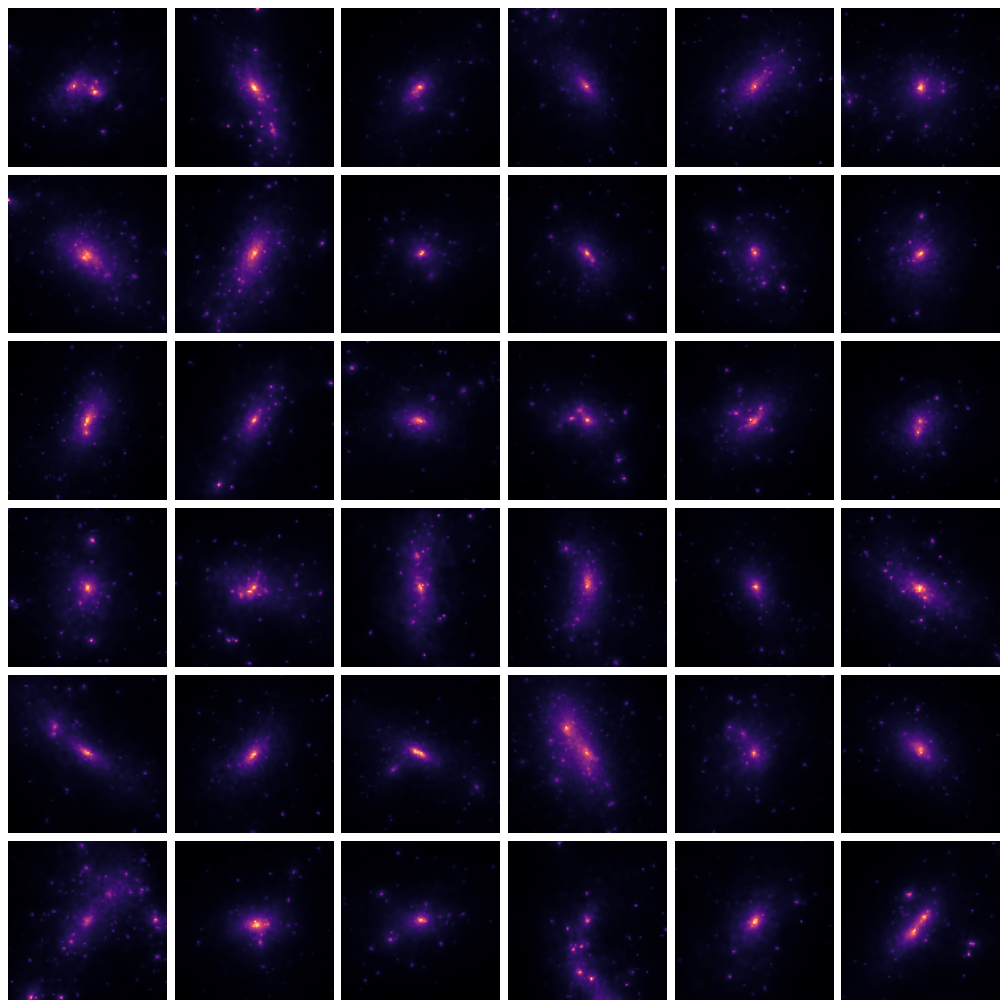

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Assuming 'x' is your data with shape (5000, 4, 100, 100)
# For demonstration, let's create some random data with that shape
# x = np.random.rand(5000, 4, 100, 100)
# Let's make the first 3 channels look like a color image and the 4th an alpha channel
# x[:, 3, :, :] = 0. # Set a constant alpha

fig = plt.figure(figsize=(16., 16.))
fig.patch.set_facecolor('white')
grid = ImageGrid(fig, 111, nrows_ncols=(6, 6), axes_pad=0.1)

# Get 36 random images from the dataset
random_images = x[np.random.randint(len(x), size=36)]

# To show only the first channel with the 'magma' colormap
for ax, im in zip(grid, random_images):
    # Select the first channel, which has shape (100, 100)
    first_channel = im[0] 
    ax.imshow(first_channel, cmap='magma') # Now cmap is used
    ax.axis('off')

# for ax, im in zip(grid, random_images):
#     # Transpose the image from (C, H, W) to (H, W, C) for Matplotlib
#     im_transposed = im.transpose(1, 2, 0)
    
#     # Now im_transposed has the shape (100, 100, 4), which imshow can handle
#     ax.imshow(im_transposed) # No cmap needed for RGBA
#     ax.axis('off')
    
plt.show()
plt.close()



## Training routine
<figure>
    <img src="./figures/training-algorithm.png" alt="G. Louppe" width="400">
    <figcaption>Training algorithm </figcaption>
</figure>

In [91]:
def train(
    train_dataset, device, batch_size: int=32, num_time_steps: int=1000, num_epochs: int=15, save_patience: int=20,
    seed: int=-1, ema_decay: float=0.9999,  lr=2e-5, checkpoint_folder_path: str=None, checkpoint_filename: str=None, input_dim: int=32,
    unet_Channels: list=[64, 128, 256, 512, 512, 384],
    unet_Attentions: list=[False, True, False, False, False, True],
    unet_Upscales: list=[False, False,False, True, True, True],
    unet_num_groups: int=32,
    unet_dropout_prob: float=0.1,
    unet_num_heads: int=8,
    unet_input_channels: int=1,
    unet_output_channels: int=1
         ):
    
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
    
    # define scheduler
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    
    # define models
    model = UNET(
            unet_Channels,
            unet_Attentions,
            unet_Upscales,
            unet_num_groups,
            unet_dropout_prob,
            unet_num_heads,
            unet_input_channels,
            unet_output_channels,
    ).to(device) 
    
    # EMA will use the device of the model it wraps, so no change needed here.
    ema = ModelEmaV3(model, decay=ema_decay)
    
    # define optmizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # load checkpoint if present
    if os.path.exists(os.path.join(checkpoint_folder_path, checkpoint_filename)):
        print('Loading previous checkpoint')
        checkpoint_path = os.path.join(checkpoint_folder_path, checkpoint_filename)
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    else:
        os.makedirs(checkpoint_folder_path, exist_ok=True)
        
    # define loss
    criterion = nn.MSELoss(reduction='mean')

    # start the training
    for i in range(num_epochs):
        total_loss = 0
        for bidx, x in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.to(device)
            x = F.pad(x, (2,2,2,2)) # Padding is fine, it operates on the tensor already on the device
            
            # FORWARD PROCESS
            # pick a random time step (t)
            t = torch.randint(0, num_time_steps, (batch_size,), device=device) # Can create tensor directly on device
            # generate noise (e)
            e = torch.randn_like(x, requires_grad=False) # Will be on the same device as x
            # define the scheduler at time t (alpha_t)
            a = scheduler.alpha[t.cpu()].view(batch_size,1,1,1).to(device)   # Move alpha slice to device
            # update x: x(0) --> x(t)
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)

            # NOISE MATCHING
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
            
        print(f'Epoch {i+1} | Loss {total_loss / len(train_loader):.5f}') # Corrected loss calculation
        
        if device.type == 'cuda':
            torch.cuda.empty_cache()
        elif device.type == 'mps':
            torch.mps.empty_cache()

        if (not i % save_patience) or (i == (num_epochs - 1)):
            print(f"Saving checkpoint at epoch {i+1}")
            # save model at the end of each epoch
            checkpoint = {
                'weights': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'ema': ema.state_dict()
            }
            save_path = os.path.join(checkpoint_folder_path, f'{checkpoint_filename}_epoch_{i+1}.pt')
            torch.save(checkpoint, save_path)

In [92]:
# import numpy as np

# # --- In your code ---
# # Assume 'x' is your dataset with shape (5000, 4, 100, 100)
# # For demonstration, let's create some dummy data if you're running this standalone

# # Assuming your original data `x_data` is a numpy array in the [0, 1] range
# print(f"Original data range: {x.min():.2f} to {x.max():.2f}")

# # Transform to [-1, 1]
# x_normalized = (x * 2.0) - 1.0

# print(f"New normalized data range: {x_normalized.min():.2f} to {x_normalized.max():.2f}")

# try:
#     x.shape
#     print(f"Using existing 'x' with shape: {x_normalized.shape}")
# except NameError:
#     print("Creating a dummy 'x' array for demonstration.")

# # 1. Define the output filename
# output_filename = 'flamingo_100x100_4ch.npy'

# # 2. Save the array to the file
# np.save(output_filename, x_normalized)

# print(f"\nSuccessfully saved the dataset to '{output_filename}'")

In [93]:
# np.min(x_normalized)

In [94]:
# define data loader
N_train = 1000
N_test = 1000
data_path='data/flamingo_100x100_4ch.npy'
input_dim=100 # crop image for computational reasons, see npy_loader()

dataset = torch.utils.data.TensorDataset(npy_loader(data_path, input_dim))
train_dataset = dataset[:N_train, :]
train_dataset = [train_dataset[0][:,0].reshape(N_train,1,input_dim,input_dim)]
test_dataset  = dataset[N_train:N_train+N_test, :]

torch.Size([5000, 4, 100, 100])
<class 'torch.Tensor'>


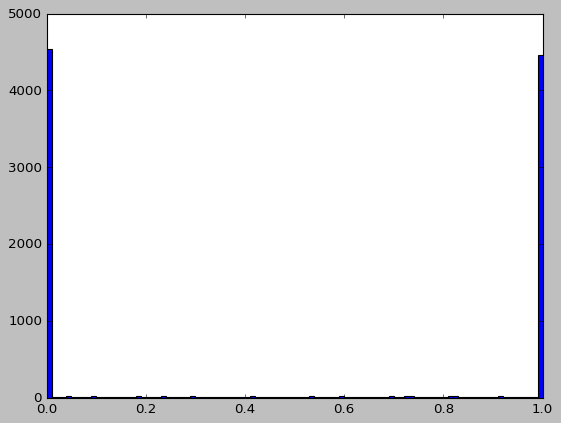

In [95]:
# plt.hist(train_dataset[0][0][0].flatten(),bins =100);

plt.hist(generated_images_tensor[0][0].flatten(),bins =100);



In [ ]:
# define hyper parameters
batch_size=24
num_time_steps=1000
num_epochs=50
seed=-1
ema_decay=0.9999
lr=2e-5

# # U-net architecture
# unet_Channels = [128, 256, 512, 512]

# unet_Attentions = [False, True, False, True]
# unet_Upscales = [False, False, True, True]
unet_num_groups = 16

unet_dropout_prob = 0.1


unet_Channels =[256, 512, 1024, 1024]
unet_Attentions  = [False, True, False, True]
unet_Upscales = [False, False, True, True]


unet_num_heads = 8
unet_input_channels = 1
unet_output_channels = 1

train(train_dataset[0],
        device = device,
        batch_size=batch_size,
        checkpoint_folder_path='./checkpoints',
        checkpoint_filename='ddpm_flamingo', 
        num_time_steps=num_time_steps,
        num_epochs=num_epochs,
        seed=seed,
        ema_decay=ema_decay,
        lr=lr,
        input_dim=input_dim,
        # checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64_30',
        unet_Channels = unet_Channels,
        unet_Attentions = unet_Attentions,
        unet_Upscales = unet_Upscales,
        unet_dropout_prob = unet_dropout_prob,
        unet_num_heads = unet_num_heads,
        unet_input_channels = unet_input_channels,
        unet_output_channels = unet_output_channels
)

Epoch 1/50:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1 | Loss 0.34500
Saving checkpoint at epoch 1


Epoch 2/50:   0%|          | 0/41 [00:00<?, ?it/s]

## Generating new samples

<figure>
    <img src="./figures/sampling-algorithm.png" alt="G. Louppe" width="400">
    <figcaption>Sampling algorithm </figcaption>
</figure>

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math


# unet_Channels =[128, 256, 512, 512]
# unet_Attentions  = [False, True, False, True]
# unet_Upscales = [False, False, True, True]
# unet_num_heads = 8

def generate_samples(
    device,
    checkpoint_path: str,
    num_samples: int = 16, # How many images to generate
    num_time_steps: int = 1000,
    image_size: int = 100,
    # --- UNET params must match your trained model ---
    unet_Channels: list=[128, 256, 512, 512],
    unet_Attentions = [False, True, False, True],
    unet_Upscales = [False, False, True, True],
    unet_input_channels: int=1,
    unet_output_channels: int=1,
    # Add other UNET params if necessary (num_groups, etc.)
):
    """
    Generates images from pure noise using the standard DDPM process.
    """
    # --- 1. Setup Model, Scheduler, and Device ---
    # This part is identical to the previous function
    checkpoint = torch.load(checkpoint_path, map_location=device)
    

    
    model = UNET(
        unet_Channels, unet_Attentions, unet_Upscales, unet_num_groups,
        unet_dropout_prob, unet_num_heads, unet_input_channels, unet_output_channels
    ).to(device)
    
    # Load EMA weights
    from collections import OrderedDict
    ema_state_dict = checkpoint.get('ema', checkpoint['weights'])
    new_state_dict = OrderedDict()
    for key, value in ema_state_dict.items():
        if key.startswith('module.'):
            new_key = key[7:]
        else:
            new_key = key
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict)
    model.eval()

    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    scheduler.alpha = scheduler.alpha.to(device) # This is actually alpha_bar
    scheduler.beta = scheduler.beta.to(device)

    # --- 2. Prepare the Initial Noise Tensor (x_T) ---
    with torch.no_grad():
        # --- FIX 1: Generate noise at the PADDED size ---
        # The model was trained on 100x100 images padded by 2 on each side.
        padded_size = image_size + 4
        
        xt = torch.randn(
            num_samples,
            unet_input_channels,
            padded_size, # e.g., 104
            padded_size, # e.g., 104
            device=device
        )
        print(f"Starting generation with padded noise tensor of shape: {xt.shape}")

    
        # --- 3. The Denoising Loop (from T-1 down to 0) ---
            
        # The loop now iterates through the *entire* time range
        for t_int in tqdm(reversed(range(num_time_steps)), desc="Denoising", total=num_time_steps):
            
            t = torch.full((num_samples,), t_int, device=device, dtype=torch.long)

            # Predict noise using the model
            predicted_noise = model(xt, t)
            
            
            # Get scheduler parameters for this timestep (using your scheduler's naming)
            beta_t = scheduler.beta[t].view(num_samples, 1, 1, 1)
            alpha_t = 1. - beta_t
            alpha_bar_t = scheduler.alpha[t].view(num_samples, 1, 1, 1)

            # DDPM sampling formula
            coeff = (beta_t) / torch.sqrt(1 - alpha_bar_t) # Corrected coeff
            mean = (1 / torch.sqrt(alpha_t)) * (xt - coeff * predicted_noise)
            
            if t_int > 0:
                # Calculate variance
                alpha_bar_t_prev = scheduler.alpha[t-1].view(num_samples, 1, 1, 1)
                variance = (1 - alpha_bar_t_prev) / (1 - alpha_bar_t) * beta_t
                z = torch.randn_like(xt)
                xt = mean + torch.sqrt(variance) * z
            else:
                xt = mean # No noise at the final step

    # We need to remove the 2-pixel border.
    final_images_padded = (xt.clamp(-1, 1) + 1) / 2 # Normalize to [0, 1]
    
    # Crop from (e.g.) 104x104 to 100x100
    final_images = final_images_padded[:, :, 2:-2, 2:-2]
    
    final_images = final_images.cpu()

    print(f"\n--- Generated Samples (cropped to {final_images.shape[-2:]}) ---")


    print("\n--- Generated Samples ---")
    grid_size = math.ceil(math.sqrt(num_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    fig.patch.set_facecolor('white')

    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            # Get the i-th image and permute from (C, H, W) to (H, W, C)
            img = final_images[i].permute(1, 2, 0)
            ax.imshow(img[:, :, :3]) # Show the first 3 channels
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return final_images

/tmp/1012651/ipykernel_2879609/1435572202.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Starting generation with padded noise tensor of shape: torch.Size([16, 1, 104, 104])


Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Generated Samples (cropped to torch.Size([100, 100])) ---

--- Generated Samples ---


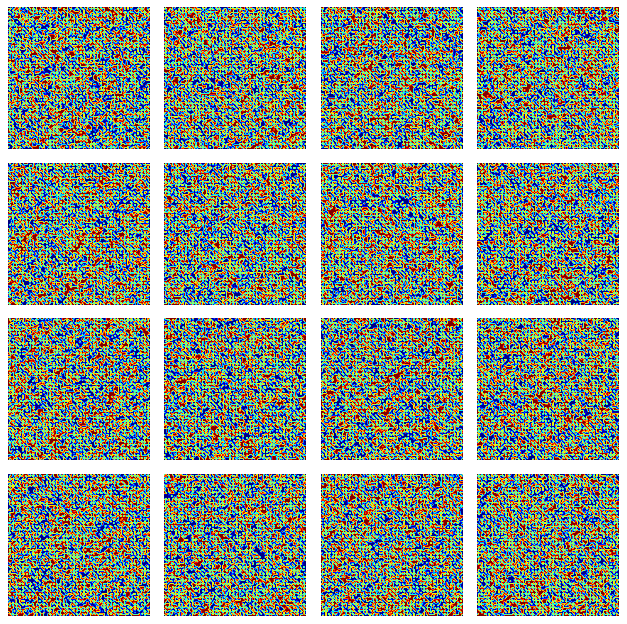

In [37]:
# Your setup code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = './checkpoints/ddpm_flamingo_epoch_100.pt' # Your path


unet_Channels =[128, 256, 512, 512]
unet_Attentions  = [False, True, False, True]
unet_Upscales = [False, False, True, True]


unet_num_groups = 16

unet_num_heads = 8
unet_input_channels = 1
unet_output_channels = 1


# Call the new generation function
generated_images_tensor = generate_samples(
    device=device,
    checkpoint_path=CHECKPOINT_PATH,
    num_samples=16, # Generate a 4x4 grid of images
    image_size=100,
    unet_Channels = unet_Channels,
    unet_Attentions = unet_Attentions,
    unet_Upscales = unet_Upscales,
    unet_input_channels=1,
    unet_output_channels=1,
    # Pass the UNET architecture that matches the checkpoint!
    # unet_Channels=..., unet_Attentions=...
)

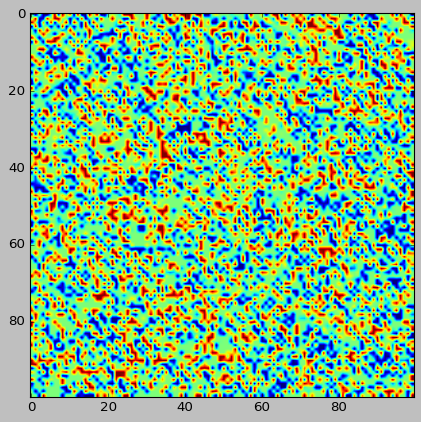

In [49]:
plt.imshow(generated_images_tensor[0][0]-generated_images_tensor[1][0])

## Generate from a given seed

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.auto import tqdm # For a nice progress bar
from collections import OrderedDict

# Make sure these class definitions are available
# from your_model_file import UNET, ModelEmaV3, DDPM_Scheduler

def generate_from_seed(
    device,
    checkpoint_path: str,
    seed_image: torch.Tensor,
    t_start: int,
    num_time_steps: int = 1000,
    image_size: int = 100, # Changed from input_dim for clarity
    # --- UNET params should match your trained model ---
    unet_Channels: list=[128, 256, 512, 512],
    unet_Attentions = [False, True, False, True],
    unet_Upscales = [False, False, True, True],
    unet_num_groups: int=32,
    unet_dropout_prob: float=0.1,
    unet_num_heads: int=8,
    unet_input_channels: int=4,
    unet_output_channels: int=4
):
    """
    Generates an image by starting with a seed image, adding noise, and then denoising.
    """
    # --- 1. Setup Model, Scheduler, and Device ---
    
    # Load checkpoint onto the target device directly
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Initialize model and load its weights
    model = UNET(
        unet_Channels, unet_Attentions, unet_Upscales, unet_num_groups,
        unet_dropout_prob, unet_num_heads, unet_input_channels, unet_output_channels
    ).to(device)
    
    # Use the EMA weights for inference for better results
    # No need for the full ModelEmaV3 class here, just load the state dict
    # Note: If your checkpoint saves the raw EMA weights, you might need to adjust.
    # Assuming the checkpoint['ema'] contains the model's state_dict.
    ema_state_dict = checkpoint.get('ema', checkpoint['weights'])

    # The keys in the checkpoint are prefixed with 'module.'.
    # We need to remove this prefix to match the keys in the local model.
    # We'll create a new dictionary with the corrected keys.
    new_state_dict = OrderedDict()
    
    for key, value in ema_state_dict.items():
        if key.startswith('module.'):
            # Create a new key by removing the 'module.' prefix
            new_key = key[7:] 
        else:
            new_key = key
        new_state_dict[new_key] = value

    # Load the corrected state dictionary
    model.load_state_dict(new_state_dict)
    # --- END OF NEW LOGIC ---

    model.eval() # Set model to evaluation mode
    
    t_start_tensor = torch.tensor([t_start - 1], device=device) # t is 0-indexed

    # Initialize scheduler and move its tensors to the correct device
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    scheduler.alpha = scheduler.alpha.to(device) # This is actually moving alpha_bar
    scheduler.beta = scheduler.beta.to(device)
    a_bar_t = scheduler.alpha[t_start_tensor] # Use .alpha because that's what you named alpha_bar


# --- 2. Prepare the Initial Noisy Image ---
    with torch.no_grad():
        # Ensure seed image has batch dimension and is on the correct device
        x0 = seed_image.unsqueeze(0).to(device)

        # Get the noise schedule for the starting time step

        # Now we can safely use it.
        # This uses your scheduler's .alpha (which is really alpha_bar)
        a_bar_t = scheduler.alpha[t_start_tensor]

        # Correctly add noise according to the DDPM forward process formula
        noise = torch.randn_like(x0)
        xt = torch.sqrt(a_bar_t) * x0 + torch.sqrt(1 - a_bar_t) * noise
        
        # --- Visualize Starting Point ---
        print(f"Starting with seed image, adding noise for t={t_start}")
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original Image
        img_for_plot_orig = x0.squeeze(0).cpu().permute(1, 2, 0)
        axes[0].imshow(img_for_plot_orig[:,:,:3]) # Show first 3 channels (RGB)
        axes[0].set_title("Original Seed Image")
        axes[0].axis('off')
        
        # Noisy Image
        img_for_plot_noisy = xt.squeeze(0).cpu().permute(1, 2, 0)
        axes[1].imshow(img_for_plot_noisy[:,:,:3])
        axes[1].set_title(f"Noisy Image at t={t_start}")
        axes[1].axis('off')
        plt.show()
        

        # --- 3. The Denoising Loop ---
        print("Starting denoising process...")
        for t_int in tqdm(reversed(range(t_start)), desc="Denoising"):
            t = torch.full((1,), t_int, device=device, dtype=torch.long)
            
            # Predict noise using the model
            predicted_noise = model(xt, t)
            
            # Get scheduler parameters for this timestep

            beta_t = scheduler.beta[t]
            alpha_t = 1 - beta_t # Calculate the real alpha on the fly
            alpha_bar_t = scheduler.alpha[t] # Use .alpha because that's what you named alpha_bar
            coeff = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
            # DDPM sampling formula
            coeff = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
            mean = (1 / torch.sqrt(alpha_t)) * (xt - coeff * predicted_noise)
            
            if t_int > 0:
                variance = beta_t
                z = torch.randn_like(xt)
                xt = mean + torch.sqrt(variance) * z
            else:
                xt = mean # No noise at the final step

    # --- 4. Final Result ---
    final_image = xt.squeeze(0).cpu()

    # Visualize the final denoised image
    plt.figure(figsize=(8, 8))
    plt.imshow(final_image.permute(1, 2, 0)[:,:,:3])
    plt.title("Final Denoised Image")
    plt.axis('off')
    plt.show()

    return final_image

Using device: cuda


/tmp/1012651/ipykernel_2796754/1210407403.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Clipping input d

Starting with seed image, adding noise for t=500


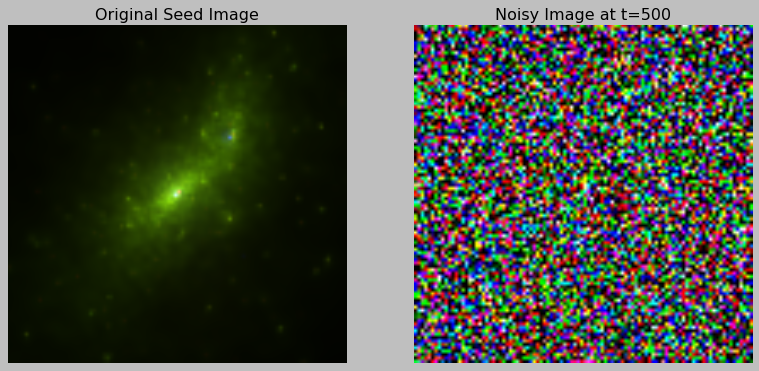

Starting denoising process...


Denoising: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-12.954803..16.00147].


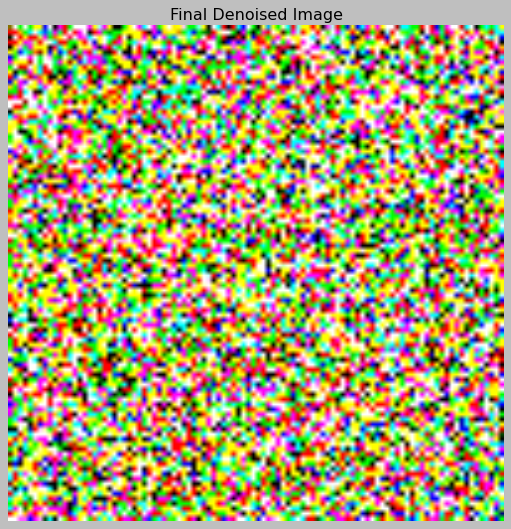

In [28]:
# 1. Define your device (you should already have this)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# 2. Load your data and pick a seed image
# Assuming 'x_data' is your dataset of shape (5000, 4, 100, 100)
x_data = np.load('flamingo_100x100_4ch.npy')
x_data = torch.from_numpy(x_data).float()

# Let's pick the 10th image as our seed
seed_image = x_data[10] 

# 3. Define paths and parameters
CHECKPOINT_PATH = './checkpoints/ddpm_flamingo_epoch_11.pt' # Use a specific, saved checkpoint
T_START = 500 # How much noise to add initially (from 1 to 1000)
IMAGE_SIZE = 100
NUM_CHANNELS = 4


# 4. Run the generation
generated_image = generate_from_seed(
    device=device,
    checkpoint_path=CHECKPOINT_PATH,
    seed_image=seed_image,
    t_start=T_START,
    image_size=IMAGE_SIZE,
    unet_input_channels=NUM_CHANNELS,
    unet_output_channels=NUM_CHANNELS
    # Ensure other UNET params match your training!
)

In [29]:
def generate_and_visualize_channels(
    # Pass all the same arguments as generate_from_seed
    device, checkpoint_path, seed_image, t_start,
    # Add any other necessary model/scheduler params here
    **kwargs 
):
    """
    Calls the generation function and then visualizes the output,
    showing a composite view and each individual channel.
    """
    # 1. Generate the final 4-channel image using the existing function
    print("--- Step 1: Generating the multi-channel image ---")
    final_image = generate_from_seed(
        device=device,
        checkpoint_path=checkpoint_path,
        seed_image=seed_image,
        t_start=t_start,
        **kwargs # Pass along all other keyword arguments
    )
    # final_image has shape (4, H, W) and is on the CPU

    print("\n--- Step 2: Visualizing the output channels ---")
    
    # 2. Set up the plots
    # We will have 1 plot for the composite RGB and 4 for the individual channels
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    fig.patch.set_facecolor('white')

    # 3. Plot the composite "RGB" image (using the first 3 channels)
    # Permute from (C, H, W) to (H, W, C) for imshow
    composite_img = final_image.permute(1, 2, 0)
    axes[0].imshow(composite_img[:, :, :3]) # Slicing ensures we only use 3 channels for RGB
    axes[0].set_title("Composite (Channels 0,1,2)")
    axes[0].axis('off')

    # 4. Loop through and plot each channel individually
    for i in range(4):
        # Data for this channel is a 2D tensor, shape (H, W)
        channel_img = final_image[i]
        
        # Use a colormap since it's a single channel (grayscale data)
        im = axes[i+1].imshow(channel_img, cmap='magma')
        axes[i+1].set_title(f"Denoised Channel {i}")
        axes[i+1].axis('off')
        fig.colorbar(im, ax=axes[i+1], orientation='vertical') # Add a colorbar for scale

    plt.tight_layout()
    plt.show()

--- Step 1: Generating the multi-channel image ---


/tmp/1012651/ipykernel_2796754/1210407403.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Clipping input d

Starting with seed image, adding noise for t=100


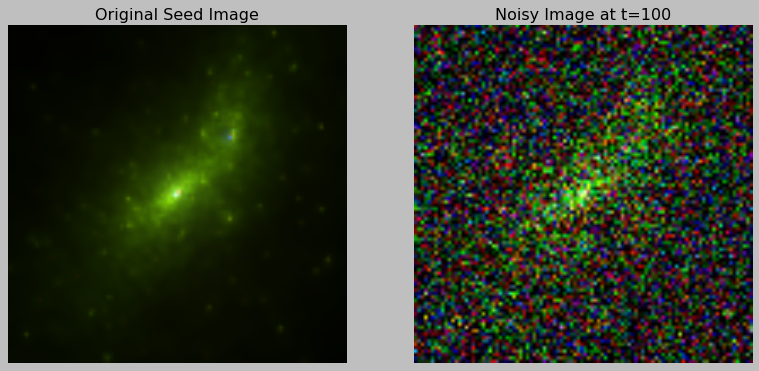

Starting denoising process...


Denoising: 0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6839985..2.140661].


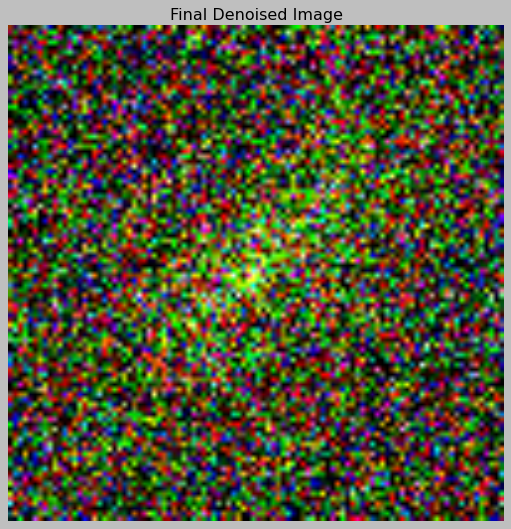

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6839985..2.140661].



--- Step 2: Visualizing the output channels ---


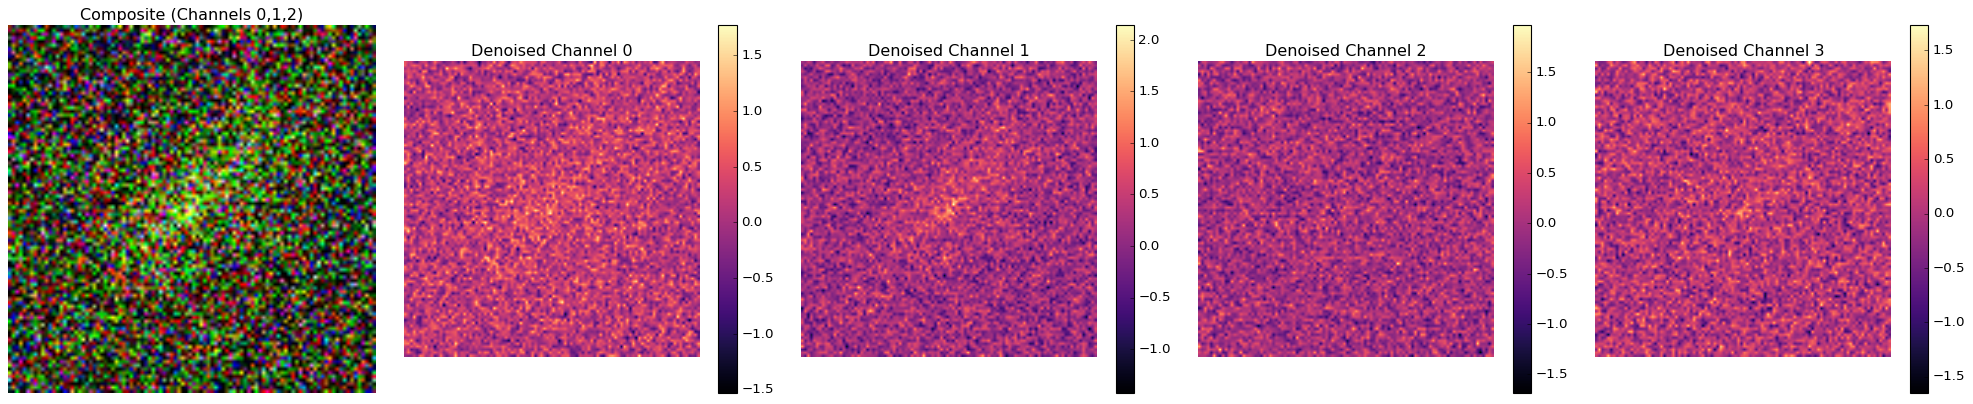

In [34]:
# --- Your setup code remains the same ---
# (device selection, loading data, picking seed_image, etc.)

# Define paths and parameters
CHECKPOINT_PATH = './checkpoints/ddpm_flamingo_epoch_11.pt' # Use your actual path
T_START = 100
IMAGE_SIZE = 100
NUM_CHANNELS = 4

# Call the NEW visualization function
generate_and_visualize_channels(
    device=device,
    checkpoint_path=CHECKPOINT_PATH,
    seed_image=seed_image,
    t_start=T_START,
    
    # It is CRITICAL to pass the correct model architecture here
    image_size=IMAGE_SIZE,
    unet_input_channels=NUM_CHANNELS,
    unet_output_channels=NUM_CHANNELS,
    # unet_Channels=... , unet_Attentions=... etc.
)

In [59]:
import torch

# Path to your checkpoint
CHECKPOINT_PATH = './checkpoints/ddpm_flamingo_epoch_11.pt' # Use your actual path

# Load the checkpoint onto the CPU for inspection
checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')

print("Top-level keys in checkpoint:", checkpoint.keys())
# Expected output: dict_keys(['weights', 'optimizer', 'ema'])

# Now, let's look inside the 'ema' dictionary
ema_state = checkpoint['ema']

# Print the first 5 keys from the EMA state to see what they look like
print("\nFirst 5 keys inside the 'ema' dictionary:", list(ema_state.keys())[:5])
# Expected output: ['down_blocks.0.res.in_layers.2.weight', 'down_blocks.0.res.in_layers.2.bias', ...etc]
# CRUCIALLY, you will NOT see 'module' in this list.

Top-level keys in checkpoint: dict_keys(['weights', 'optimizer', 'ema'])

First 5 keys inside the 'ema' dictionary: ['module.shallow_conv.weight', 'module.shallow_conv.bias', 'module.late_conv.weight', 'module.late_conv.bias', 'module.output_conv.weight']


/tmp/1012651/ipykernel_2775366/1864724049.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')


In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def plot_inference(
    N: int=10,
    output_path: str=None,
    checkpoint_path: str=None,
    num_time_steps: int=1000,
    ema_decay: float=0.9999, 
    input_dim: int=32,
    unet_Channels: list=[64, 128, 256, 512, 512, 384], 
    unet_Attentions: list=[False, True, False, False, False, True],
    unet_Upscales: list=[False, False, False, True, True, True],
    unet_num_groups: int=32,
    unet_dropout_prob: float=0.1,
    unet_num_heads: int=8,
    unet_input_channels: int=4,
    unet_output_channels: int=4,
    my_seed=None,  # Your custom seed or initial image
    t_start: int = 500  # Time step to start denoising from (adds corresponding noise level)
):
    # Load checkpoint with CPU map location
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model = UNET(
        unet_Channels,
        unet_Attentions,
        unet_Upscales,
        unet_num_groups,
        unet_dropout_prob,
        unet_num_heads,
        unet_input_channels,
        unet_output_channels,
    ).to('cpu')  # Ensure model is on CPU
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

    # Only the final step or a few denoising steps
    times = [num_time_steps - 1]
    
    # Prepare for saving images if needed
    images = []

    # Start denoising process
    with torch.no_grad():
        model = ema.module.eval()
        for i in range(N):
            # Start with the custom seed image
            z = my_seed.reshape(1, unet_input_channels, input_dim, input_dim)

            
            plt.imshow(z.reshape(input_dim, -1) )
            plt.show()
                       
            # Add noise corresponding to t_start
            noise_level = scheduler.beta[t_start]
            z_noisy = z + torch.sqrt(noise_level) * torch.randn_like(z)  # Add noise to the seed

            # Plot the noisy image
            plt.imshow(z_noisy.squeeze(0).squeeze(0).cpu().numpy(), cmap='magma')
            plt.title(f"Noisy image (start at step {t_start})")
            plt.show()

            # Start denoising process from t_start
            z = z_noisy
            for t in reversed(range(t_start, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z, t))
                
                # Visualize intermediate denoising steps
                if t[0] % 100 == 0:  # Plot every 100 steps (adjust as needed)
                    plt.imshow(z.squeeze(0).squeeze(0).cpu().numpy(), cmap='magma')
                    plt.title(f"Denoising step {t[0]}")
                    plt.show()
                    
                if t[0] in times:
                    images.append(z)
                    
                # Add Gaussian noise for the diffusion process
                e = torch.randn(1, 1, input_dim, input_dim)
                z = z + (e * torch.sqrt(scheduler.beta[t]))

            # Final denoised image after backward process
            temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
            x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z, [0]))

            images.append(x)
            
            # Display the final image
            x = x.squeeze(0).squeeze(0).cpu().numpy()
            fig = plt.figure(figsize=(8, 6))
            fig.patch.set_facecolor('white')
            plt.imshow(x, cmap='magma')
            plt.title("Final denoised image")
            plt.show()
            plt.close()
    
    # Concatenate images if needed
    images = torch.concat(images, dim=0)

    # Save the images if output path is provided
    if output_path is not None:
        save_path = Path(output_path)
        os.makedirs(str(save_path.parent), exist_ok=True)
        if os.path.exists(output_path):
            print("Load previous samples")
            images_old = torch.from_numpy(np.load(output_path))
            print("number of previous generated samples: ", images_old.shape[0])
            images = torch.concat([images_old, images], dim=0)
            print("number of total generated samples: ", images.shape[0])
        np.save(save_path, images.cpu().numpy())

    return images


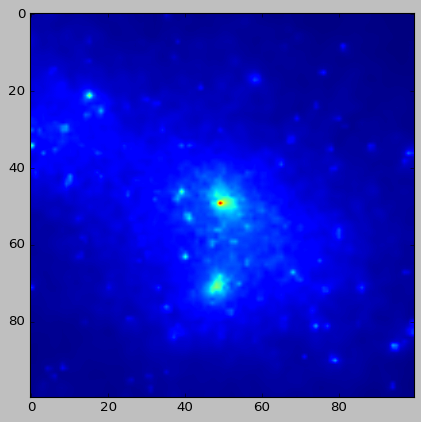

In [34]:
plt.imshow(train_dataset[0][0][0])

In [43]:
scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

e = torch.randn(1, 1, input_dim, input_dim)
noise = (e * torch.sqrt(scheduler.beta[1]))
noise

tensor([[[[ 0.0100, -0.0057,  0.0063,  ..., -0.0066, -0.0070,  0.0071],
          [ 0.0011,  0.0181,  0.0290,  ...,  0.0077,  0.0041, -0.0091],
          [-0.0012, -0.0084,  0.0353,  ...,  0.0167, -0.0214, -0.0095],
          ...,
          [-0.0032,  0.0250,  0.0021,  ..., -0.0073, -0.0149, -0.0145],
          [-0.0181,  0.0144, -0.0068,  ...,  0.0127, -0.0059, -0.0059],
          [ 0.0051,  0.0032,  0.0057,  ...,  0.0117,  0.0185,  0.0085]]]])

/tmp/1012651/ipykernel_2775366/4266083887.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


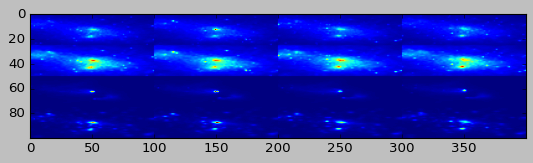

TypeError: Invalid shape (4, 100, 100) for image data

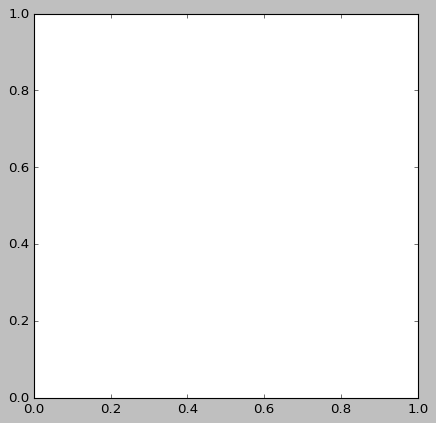

In [44]:
#epoch 80
images = plot_inference(N=1,
    checkpoint_path='checkpoints/ddpm_flamingo_epoch_11.pt',
    num_time_steps = 2, 
    input_dim=input_dim,
    unet_Channels=unet_Channels,
    unet_Attentions=unet_Attentions,
    unet_Upscales=unet_Upscales,
    unet_num_groups=unet_num_groups,
    unet_dropout_prob=unet_dropout_prob,
    unet_num_heads=unet_num_heads,
    unet_input_channels=unet_input_channels,
    unet_output_channels=unet_output_channels,
    my_seed = train_dataset[0][0],
    t_start = 1 # Time step to start denoising from (adds corresponding noise level)
         )

In [40]:
train_dataset[0][0].shape

torch.Size([4, 100, 100])

In [45]:
def generate(
        N,
        output_path: str=None,
        plot_images: bool=False,
        checkpoint_path: str=None,
        num_time_steps: int=1000,
        ema_decay: float=0.9999,
        input_dim: int=32,
        unet_Channels: List=[64, 128, 256, 512, 512, 384],
        unet_Attentions: List=[False, True, False, False, False, True],
        unet_Upscales: List=[False, False, False, True, True, True],
        unet_num_groups: List=32,
        unet_dropout_prob: List=0.1,
        unet_num_heads: List=8,
        unet_input_channels: List = 4,
        unet_output_channels: List = 4,
             ):
    '''
    Generate N new images and save them in .npy file if declared in output_path
    '''
    checkpoint = torch.load(checkpoint_path)
    model = UNET(
        unet_Channels,
        unet_Attentions,
        unet_Upscales,
        unet_num_groups,
        unet_dropout_prob,
        unet_num_heads,
        unet_input_channels,
        unet_output_channels,
    ).cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(N):
            z = torch.randn(1, 1, input_dim, input_dim)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                e = torch.randn(1, 1, input_dim, input_dim)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())
            images.append(x)
            if plot_images:
                x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
                x = x.numpy()
                fig = plt.figure(figsize=(8, 6))
                fig.patch.set_facecolor('white')
                plt.imshow(x, cmap='magma')
                plt.show()
                plt.close()
    images = torch.concat(images, dim=0)
    if output_path !=None:
        save_path= Path(output_path)
        os.makedirs(str(save_path.parent), exist_ok=True)
        if os.path.exists(output_path):
            print("Load previous samples")
            images_old = torch.from_numpy(np.load(output_path))
            print("number of previous generated samples: ", images_old.shape[0])
            images = torch.concat([images_old, images], dim=0)
            print("number of total generated samples: ", images.shape[0])
        np.save(save_path, images.numpy())
    return images

def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    fig.patch.set_facecolor('white')
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x, cmap='magma')
        ax.axis('off')
    plt.show()
    plt.close()
    
def plot_inference(
    N: int=10,
    checkpoint_path: str=None,
    num_time_steps: int=1000,
    ema_decay: float=0.9999, 
    input_dim: int=32,
    unet_Channels: List=[64, 128, 256, 512, 512, 384], 
    unet_Attentions: List = [False, True, False, False, False, True],
    unet_Upscales: List = [False, False, False, True, True, True],
    unet_num_groups: List = 32,
    unet_dropout_prob: List = 0.1,
    unet_num_heads: List = 8,
    unet_input_channels: List = 4,
    unet_output_channels: List = 4,
             ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET(
        unet_Channels,
            unet_Attentions,
            unet_Upscales,
            unet_num_groups,
            unet_dropout_prob,
            unet_num_heads,
            unet_input_channels,
            unet_output_channels,
    ).cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(N):
            z = torch.randn(1, 1, input_dim, input_dim)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, input_dim, input_dim)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            fig = plt.figure(figsize=(8, 6))
            fig.patch.set_facecolor('white')
            plt.imshow(x, cmap='magma')
            plt.show()
            plt.close()
            display_reverse(images)
            images = []

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

def plot_inference(
    N: int=10,
    output_path: str=None,
    checkpoint_path: str=None,
    num_time_steps: int=1000,
    ema_decay: float=0.9999, 
    input_dim: int=32,
    unet_Channels: list=[64, 128, 256, 512, 512, 384], 
    unet_Attentions: list=[False, True, False, False, False, True],
    unet_Upscales: list=[False, False, False, True, True, True],
    unet_num_groups: int=32,
    unet_dropout_prob: float=0.1,
    unet_num_heads: int=8,
    unet_input_channels: int=4,
    unet_output_channels: int=4,
    my_seed=None,  # Your custom seed or initial image
    t_start: int = 500  # Time step to start denoising from (adds corresponding noise level)
):
    # Load checkpoint with CPU map location
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model = UNET(
        unet_Channels,
        unet_Attentions,
        unet_Upscales,
        unet_num_groups,
        unet_dropout_prob,
        unet_num_heads,
        unet_input_channels,
        unet_output_channels,
    ).to('cpu')  # Ensure model is on CPU
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

    # Only the final step or a few denoising steps
    times = [num_time_steps - 1]
    
    # Prepare for saving images if needed
    images = []

    # Start denoising process
    with torch.no_grad():
        model = ema.module.eval()
        for i in range(N):
            # Start with the custom seed image
            z = my_seed.reshape(1, 1, input_dim, input_dim)

            
            plt.imshow(z.reshape(input_dim, -1) )
            plt.show()
                       
            # Add noise corresponding to t_start
            noise_level = scheduler.beta[t_start]
            z_noisy = z + torch.sqrt(noise_level) * torch.randn_like(z)  # Add noise to the seed

            # Plot the noisy image
            plt.imshow(z_noisy.squeeze(0).squeeze(0).cpu().numpy(), cmap='magma')
            plt.title(f"Noisy image (start at step {t_start})")
            plt.show()

            # Start denoising process from t_start
            z = z_noisy
            for t in reversed(range(t_start, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t] / ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t]))))
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z, t))
                
                # Visualize intermediate denoising steps
                if t[0] % 100 == 0:  # Plot every 100 steps (adjust as needed)
                    plt.imshow(z.squeeze(0).squeeze(0).cpu().numpy(), cmap='magma')
                    plt.title(f"Denoising step {t[0]}")
                    plt.show()
                    
                if t[0] in times:
                    images.append(z)
                    
                # Add Gaussian noise for the diffusion process
                e = torch.randn(1, 1, input_dim, input_dim)
                z = z + (e * torch.sqrt(scheduler.beta[t]))

            # Final denoised image after backward process
            temp = scheduler.beta[0] / ((torch.sqrt(1 - scheduler.alpha[0])) * (torch.sqrt(1 - scheduler.beta[0])))
            x = (1 / (torch.sqrt(1 - scheduler.beta[0]))) * z - (temp * model(z, [0]))

            images.append(x)
            
            # Display the final image
            x = x.squeeze(0).squeeze(0).cpu().numpy()
            fig = plt.figure(figsize=(8, 6))
            fig.patch.set_facecolor('white')
            plt.imshow(x, cmap='magma')
            plt.title("Final denoised image")
            plt.show()
            plt.close()
    
    # Concatenate images if needed
    images = torch.concat(images, dim=0)

    # Save the images if output path is provided
    if output_path is not None:
        save_path = Path(output_path)
        os.makedirs(str(save_path.parent), exist_ok=True)
        if os.path.exists(output_path):
            print("Load previous samples")
            images_old = torch.from_numpy(np.load(output_path))
            print("number of previous generated samples: ", images_old.shape[0])
            images = torch.concat([images_old, images], dim=0)
            print("number of total generated samples: ", images.shape[0])
        np.save(save_path, images.cpu().numpy())

    return images


In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from PIL import Image
import datetime
import pickle
import time 

def plot_inference(
    N: int=10,
    output_path: str=None,
    checkpoint_path: str=None,
    num_time_steps: int=1000,
    ema_decay: float=0.9999, 
    input_dim: int=32,
    unet_Channels: list=[64, 128, 256, 512, 512, 384], 
    unet_Attentions: list=[False, True, False, False, False, True],
    unet_Upscales: list=[False, False, False, True, True, True],
    unet_num_groups: int=32,
    unet_dropout_prob: float=0.1,
    unet_num_heads: int=8,
    unet_input_channels: int=4,
    unet_output_channels: int=4,
    my_seed=None,  # Custom seed or initial image
    t_start: int=500,  # Step to start denoising from
    save_intermediate=False  # Save intermediate images
):
    # Load checkpoint with CPU map location
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model = UNET(
        unet_Channels,
        unet_Attentions,
        unet_Upscales,
        unet_num_groups,
        unet_dropout_prob,
        unet_num_heads,
        unet_input_channels,
        unet_output_channels,
    ).to('cpu')
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)

    images = []
    times = [num_time_steps - 1]
    generated_samples = 0
    time_start = time.time()
    
    # Generate samples with forward-backward process
    with torch.no_grad():
        model = ema.module.eval()
        for i in range(N):
            z = my_seed.reshape(1, unet_input_channels, input_dim, input_dim)

            noise_level = scheduler.beta[t_start]
            z_noisy = z + torch.sqrt(noise_level) * torch.randn_like(z)
            
            # Save noisy image if enabled
            if save_intermediate:
                img_path = f"{output_path}/noisy_{i}_step_{t_start}.jpeg"
                save_image(z_noisy, img_path)

            # Denoise through backward process
            z = z_noisy
            for t in reversed(range(t_start, num_time_steps)):
                temp = (
                    scheduler.beta[t] /
                    ((torch.sqrt(1 - scheduler.alpha[t])) * (torch.sqrt(1 - scheduler.beta[t])))
                )
                z = (1 / (torch.sqrt(1 - scheduler.beta[t]))) * z - (temp * model(z, [t]))
                
                if save_intermediate and t % 100 == 0:
                    img_path = f"{output_path}/denoising_{i}_step_{t}.jpeg"
                    save_image(z, img_path)
                
                # Optionally save denoised samples
                if t in times:
                    images.append(z)

                z = z + (torch.randn_like(z) * torch.sqrt(scheduler.beta[t]))

            x = z.squeeze().cpu().numpy()
            fig = plt.figure(figsize=(8, 6))
            fig.patch.set_facecolor('white')
            plt.imshow(x, cmap='magma')
            plt.title("Final denoised image")
            plt.show()
            plt.close()

            images.append(x)
            generated_samples += 1

    # Save all images if output_path is provided
    if output_path is not None:
        save_path = Path(output_path)
        os.makedirs(str(save_path.parent), exist_ok=True)
        images = torch.stack(images)
        np.save(save_path, images.cpu().numpy())

    print(f"Created {generated_samples} samples in {time.time() - time_start:.1f} seconds")
    return images

def save_image(tensor, path):
    img = tensor.squeeze().cpu().numpy()
    img = ((img + 1) * 127.5).clip(0, 255).astype(np.uint8)
    img_pil = Image.fromarray(img)
    img_pil.save(path)


In [50]:
#epoch 80
images = plot_inference(N=1,
    checkpoint_path='checkpoints/ddpm_flamingo_epoch_11.pt',
    num_time_steps = 100, 
    input_dim=input_dim,
    unet_Channels=unet_Channels,
    unet_Attentions=unet_Attentions,
    unet_Upscales=unet_Upscales,
    unet_num_groups=unet_num_groups,
    unet_dropout_prob=unet_dropout_prob,
    unet_num_heads=unet_num_heads,
    unet_input_channels=unet_input_channels,
    unet_output_channels=unet_output_channels,
    my_seed = train_dataset[0][0],
    t_start = 1 # Time step to start denoising from (adds corresponding noise level)
         )

/tmp/1012651/ipykernel_2775366/3414959547.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


AttributeError: 'list' object has no attribute 'cpu'

In [51]:
#epoch 80
plot_inference(N=2,
    checkpoint_path='checkpoints/ddpm_flamingo_epoch_11.pt',
    input_dim=input_dim,
    unet_Channels=unet_Channels,
    unet_Attentions=unet_Attentions,
    unet_Upscales=unet_Upscales,
    unet_num_groups=unet_num_groups,
    unet_dropout_prob=unet_dropout_prob,
    unet_num_heads=unet_num_heads,
    unet_input_channels=unet_input_channels,
    unet_output_channels=unet_output_channels,
         )

/tmp/1012651/ipykernel_2775366/3414959547.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))


AttributeError: 'NoneType' object has no attribute 'reshape'

### QUEST
Can you modify the code to handle the full size image (128x128 pixels)?

_________________________
# Part 2: How to quantify the goodness of a generative model??

To quantify the goodness of the generator one can perform two sample tests based on binary classifiers between the samples. 
Before starting this sesssion, have a look at **tutorial 3** for an introduction to two-smaple testing. 


## Generate test sample
Let's start by generating new images to compare with the original ones

In [53]:
images = generate(
        N=2,
        # output_path='./generation/ddpm_generation_centercrop64.npy',
        plot_images=True,
        checkpoint_path='checkpoints/ddpm_flamingo_epoch_11.pt',
        input_dim=64,
        unet_Channels=[128, 256, 512, 512],
        unet_Attentions=[False, True, False, True],
        unet_Upscales=[False, False, True, True],
        unet_num_groups=64,
        unet_dropout_prob=0.1,
        unet_num_heads=8,
        unet_input_channels=1,
        unet_output_channels=1,
             )

/tmp/1012651/ipykernel_2775366/3998471318.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


RuntimeError: Error(s) in loading state_dict for UNET:
	size mismatch for shallow_conv.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 1, 3, 3]).
	size mismatch for output_conv.weight: copying a param with shape torch.Size([4, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 192, 1, 1]).
	size mismatch for output_conv.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([1]).

In [55]:
images = generate(
        N=100,
        # output_path='./generation/ddpm_generation_centercrop64.npy',
        plot_images=False,
        checkpoint_path='checkpoints/ddpm_flamingo_epoch_11.pt',
        input_dim=100,
        unet_Channels=[128, 256, 512, 512],
        unet_Attentions=[False, True, False, True],
        unet_Upscales=[False, False, True, True],
        unet_num_groups=64,
        unet_dropout_prob=0.1,
        unet_num_heads=8,
        unet_input_channels=4,
        unet_output_channels=4
             )

/tmp/1012651/ipykernel_2775366/3998471318.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


RuntimeError: Given groups=1, weight of size [128, 4, 3, 3], expected input[1, 1, 100, 100] to have 4 channels, but got 1 channels instead

### Load data

In [102]:
N_train = 4000
N_test = 2000
data_path='./galaxy/cosmos_128.npy'
input_dim=64

# original data
dataset = torch.utils.data.TensorDataset(npy_loader(data_path, input_dim))
train_dataset = dataset[:N_train, :]
test_dataset  = dataset[N_train:N_train+N_test, :]
# generated data
gen_dataset = torch.from_numpy(np.load('./generation/ddpm_generation_centercrop64.npy'))

torch.Size([6210, 1, 64, 64])


In [152]:
sample_1 = gen_dataset
sample_0 = test_dataset[0]
N_0, N_1 = sample_0.shape[0], sample_1.shape[0]

relative_weight = sample_1.shape[0]*1./sample_0.shape[0]
print('relative weight: ', relative_weight)
weight_1  = torch.ones((N_1,1))
weight_0  = torch.ones((N_0,1))*relative_weight

data_tr = torch.concat([sample_0, sample_1])
weight_tr = torch.concat([weight_0, weight_1])
target_0 = torch.zeros((N_0,1))
target_1 = torch.ones((N_1,1))
target_tr = torch.concat([target_0, target_1])

train_loader = DataLoader(list(zip(data_tr, target_tr, weight_tr)), batch_size=N_0+N_1, shuffle=True, drop_last=True, num_workers=4)

relative weight:  0.108


## Design a binary classifier model
Let's define a CNN architecture for the binary classifier
code from 
<a href="https://discuss.pytorch.org/t/binary-classification-with-cnn-from-scratch/30588" target="_blank"> PyTorch forum</a>


In [153]:
class CNN_classifier(nn.Module):
    def __init__(self, 
                channels: int=1, 
                CNN_layers: List=[64, 32, 16, 8],
                DNN_layers: List=[16, 4, 2],
                dropout: float=0.1,
               ):
        super(CNN_classifier, self).__init__()
        self.hidden_cnn = nn.ModuleList([nn.Conv2d(CNN_layers[i], CNN_layers[i+1], channels, padding=1) for i in range(len(CNN_layers)-1)])
        self.transit_dim = CNN_layers[-1]
        self.transit = nn.Linear(self.transit_dim*(1+self.transit_dim), DNN_layers[0])
        self.hidden_dnn = nn.ModuleList([nn.Linear(DNN_layers[i], DNN_layers[i+1]) for i in range(len(DNN_layers)-1)])
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.MaxPool2d(2, 2)
        self.LeakyReLU=nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        for i, cnn in enumerate(self.hidden_cnn):
            x = self.LeakyReLU(cnn(x))
            x = self.pool(x)
            #print(x.shape)
        x = x.view(-1, self.transit_dim*(1+self.transit_dim))
        x = self.dropout(x)
        x = self.LeakyReLU(self.transit(x))
        x = self.dropout(x)
        for i, dnn in enumerate(self.hidden_dnn):
            x = dnn(x)
            if i<(len(self.hidden_dnn)-1):
                x = self.LeakyReLU(x)
            x = self.sigmoid(self.dropout(x))
        return x

def weighted_binary_crossentropy(output, target, weight):
    y = target[:, 0]
    w = weight[:, 0]
    f = output[:, 0]
    return -1*torch.mean(y*w*torch.log(f) + (1-y)*w*torch.log(1-f))

def inv_sigmoid(p):
    return torch.log(p/(1-p)) 

def likelihood_ratio(true, pred, weight):
    f   = pred[:, 0]
    y   = true[:, 0]
    w = weight[:, 0]
    return 2*torch.sum((1-y)*w*(1-torch.exp(f)) + y*w*f) 

def balanced_accuracy(true, pred):
    y = true[:, 0]
    f = pred[:, 0]
    if torch.sum(1-y)>0 and torch.sum(y)>0:
        return 0.5*torch.sum((1-y)*(f<0.5))/torch.sum(1-y) + 0.5*torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)==0 and torch.sum(y)>0:
        return torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)>0 and torch.sum(y)==0:
        return torch.sum((1-y)*(f<0.5))/torch.sum(1-y)
    else:
        return torch.tensor([0])

In [147]:
# initialize model
model = CNN_classifier()
print(model)
model.cuda()

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initilie loss
criterion = weighted_binary_crossentropy

CNN_classifier(
  (hidden_cnn): ModuleList(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (transit): Linear(in_features=72, out_features=16, bias=True)
  (hidden_dnn): ModuleList(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)


### Train the binary classifier

In [148]:
loss_history = []

In [149]:
n_epochs = 200 # you may increase this number to train a final model
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    model.train()
    for idx, (data, target, weight) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        target, data, weight = target.float(), data.float(), weight.float()
        data, target, weight = data.cuda(), target.cuda(), weight.cuda()
        data, target = data.cuda(), target.cuda()
        data = rearrange(data, 'b c h w -> b h w c')
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target, weight)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss*1./len(train_loader.dataset)
    loss_history.append(train_loss)
    if not epoch%10:
        print('Epoch: {} \tTraining Loss: {:.6f}'  .format(epoch, train_loss))
    
    # save model if validation loss has decreased
    torch.save(model.state_dict(), './cnn-bce-diffusion.pt')

Epoch: 10 	Training Loss: 0.135802
Epoch: 20 	Training Loss: 0.135601
Epoch: 30 	Training Loss: 0.135195
Epoch: 40 	Training Loss: 0.135008
Epoch: 50 	Training Loss: 0.134884
Epoch: 60 	Training Loss: 0.133976
Epoch: 70 	Training Loss: 0.133384
Epoch: 80 	Training Loss: 0.132500
Epoch: 90 	Training Loss: 0.131159
Epoch: 100 	Training Loss: 0.130443
Epoch: 110 	Training Loss: 0.129107
Epoch: 120 	Training Loss: 0.127470
Epoch: 130 	Training Loss: 0.124962
Epoch: 140 	Training Loss: 0.121429
Epoch: 150 	Training Loss: 0.117363
Epoch: 160 	Training Loss: 0.113577
Epoch: 170 	Training Loss: 0.111194
Epoch: 180 	Training Loss: 0.106925
Epoch: 190 	Training Loss: 0.104289
Epoch: 200 	Training Loss: 0.103157


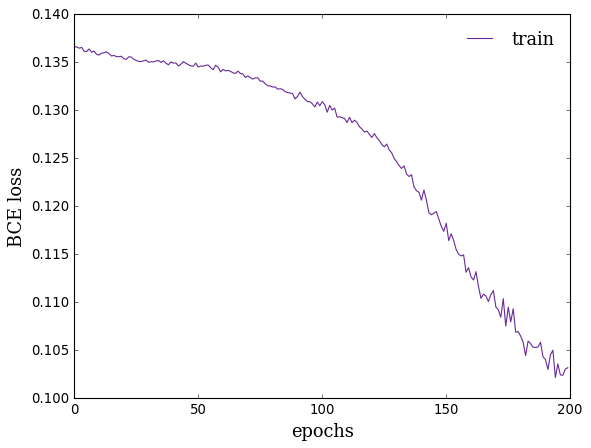

In [150]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('white')
plt.plot(loss_history, label='train', color='#692A99')#'#EA4F88')
plt.ylabel('BCE loss', fontname='serif', fontsize=16)
plt.xlabel('epochs', fontname='serif', fontsize=16)
plt.legend(prop=font, loc='best', frameon=False)
#plt.yscale('log')
plt.show() 

### Evalutate classification performance

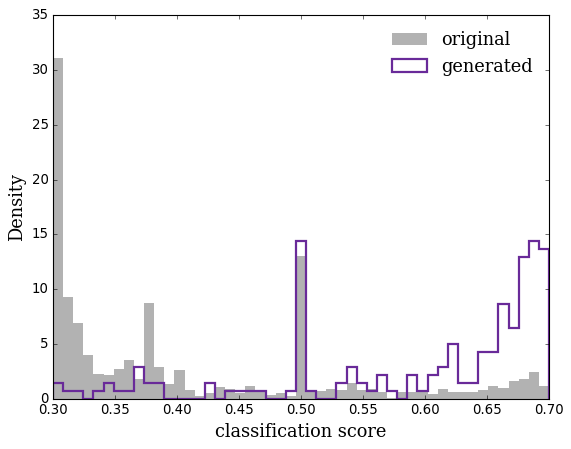

In [151]:
with torch.no_grad():
    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    output = model(data)[:, 0:1]
    bins = np.linspace(0.3,0.7,50)
    plt.hist(output[target[:, 0]==0].cpu().numpy(), bins=bins, density=True, color='black', ec='none', 
             alpha=0.3, label='original')
    plt.hist(output[target[:, 0]==1].cpu().numpy(), bins=bins, density=True, color='#692A99', 
             label='generated', histtype='step', lw=2)
    plt.xlabel("classification score", fontname='serif', fontsize=16)
    plt.ylabel("Density", fontname='serif', fontsize=16)
    #plt.yscale('log')
    plt.legend(prop=font, loc='best', frameon=False)
    plt.show()


In [154]:
output = model(data)
bacc_obs = balanced_accuracy(true=target, pred=output[:, 0:1]).item()#.cpu()
logr = inv_sigmoid(model(data))#torch.log(model(data)[:, 1:2]/model(data)[:, 0:1])#output[:, 1:2]
lrt_obs = likelihood_ratio(true=target, pred=logr, weight=weight).item()#.cpu()
print("BACC: ", bacc_obs)
print("LRT: ", lrt_obs)

BACC:  0.7922592163085938
LRT:  300.3842468261719


### metrics calibration

In [ ]:
#epoch 80
plot_inference(N=2,
    checkpoint_path='checkpoints/centercrop64_49_149',
    input_dim=input_dim,
    unet_Channels=unet_Channels,
    unet_Attentions=unet_Attentions,
    unet_Upscales=unet_Upscales,
    unet_num_groups=unet_num_groups,
    unet_dropout_prob=unet_dropout_prob,
    unet_num_heads=unet_num_heads,
    unet_input_channels=unet_input_channels,
    unet_output_channels=unet_output_channels,
         )

### QUEST
Can you modify the code to handle the full size image (128x128 pixels)?

_________________________
# Part 2: How to quantify the goodness of a generative model??

To quantify the goodness of the generator one can perform two sample tests based on binary classifiers between the samples. 
Before starting this sesssion, have a look at **tutorial 3** for an introduction to two-smaple testing. 


## Generate test sample
Let's start by generating new images to compare with the original ones

In [ ]:
images = generate(
        N=2,
        output_path='./generation/ddpm_generation_centercrop64.npy',
        plot_images=True,
        checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
        input_dim=64,
        unet_Channels=[128, 256, 512, 512],
        unet_Attentions=[False, True, False, True],
        unet_Upscales=[False, False, True, True],
        unet_num_groups=64,
        unet_dropout_prob=0.1,
        unet_num_heads=8,
        unet_input_channels=1,
        unet_output_channels=1,
             )

In [ ]:
images = generate(
        N=100,
        output_path='./generation/ddpm_generation_centercrop64.npy',
        plot_images=False,
        checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
        input_dim=64,
        unet_Channels=[128, 256, 512, 512],
        unet_Attentions=[False, True, False, True],
        unet_Upscales=[False, False, True, True],
        unet_num_groups=64,
        unet_dropout_prob=0.1,
        unet_num_heads=8,
        unet_input_channels=1,
        unet_output_channels=1,
             )

### Load data

In [ ]:
N_train = 4000
N_test = 2000
data_path='./galaxy/cosmos_128.npy'
input_dim=64

# original data
dataset = torch.utils.data.TensorDataset(npy_loader(data_path, input_dim))
train_dataset = dataset[:N_train, :]
test_dataset  = dataset[N_train:N_train+N_test, :]
# generated data
gen_dataset = torch.from_numpy(np.load('./generation/ddpm_generation_centercrop64.npy'))

In [ ]:
sample_1 = gen_dataset
sample_0 = test_dataset[0]
N_0, N_1 = sample_0.shape[0], sample_1.shape[0]

relative_weight = sample_1.shape[0]*1./sample_0.shape[0]
print('relative weight: ', relative_weight)
weight_1  = torch.ones((N_1,1))
weight_0  = torch.ones((N_0,1))*relative_weight

data_tr = torch.concat([sample_0, sample_1])
weight_tr = torch.concat([weight_0, weight_1])
target_0 = torch.zeros((N_0,1))
target_1 = torch.ones((N_1,1))
target_tr = torch.concat([target_0, target_1])

train_loader = DataLoader(list(zip(data_tr, target_tr, weight_tr)), batch_size=N_0+N_1, shuffle=True, drop_last=True, num_workers=4)

## Design a binary classifier model
Let's define a CNN architecture for the binary classifier
code from 
<a href="https://discuss.pytorch.org/t/binary-classification-with-cnn-from-scratch/30588" target="_blank"> PyTorch forum</a>


In [ ]:
class CNN_classifier(nn.Module):
    def __init__(self, 
                channels: int=1, 
                CNN_layers: List=[64, 32, 16, 8],
                DNN_layers: List=[16, 4, 2],
                dropout: float=0.1,
               ):
        super(CNN_classifier, self).__init__()
        self.hidden_cnn = nn.ModuleList([nn.Conv2d(CNN_layers[i], CNN_layers[i+1], channels, padding=1) for i in range(len(CNN_layers)-1)])
        self.transit_dim = CNN_layers[-1]
        self.transit = nn.Linear(self.transit_dim*(1+self.transit_dim), DNN_layers[0])
        self.hidden_dnn = nn.ModuleList([nn.Linear(DNN_layers[i], DNN_layers[i+1]) for i in range(len(DNN_layers)-1)])
        self.dropout = nn.Dropout(dropout)
        self.pool = nn.MaxPool2d(2, 2)
        self.LeakyReLU=nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        for i, cnn in enumerate(self.hidden_cnn):
            x = self.LeakyReLU(cnn(x))
            x = self.pool(x)
            #print(x.shape)
        x = x.view(-1, self.transit_dim*(1+self.transit_dim))
        x = self.dropout(x)
        x = self.LeakyReLU(self.transit(x))
        x = self.dropout(x)
        for i, dnn in enumerate(self.hidden_dnn):
            x = dnn(x)
            if i<(len(self.hidden_dnn)-1):
                x = self.LeakyReLU(x)
            x = self.sigmoid(self.dropout(x))
        return x

def weighted_binary_crossentropy(output, target, weight):
    y = target[:, 0]
    w = weight[:, 0]
    f = output[:, 0]
    return -1*torch.mean(y*w*torch.log(f) + (1-y)*w*torch.log(1-f))

def inv_sigmoid(p):
    return torch.log(p/(1-p)) 

def likelihood_ratio(true, pred, weight):
    f   = pred[:, 0]
    y   = true[:, 0]
    w = weight[:, 0]
    return 2*torch.sum((1-y)*w*(1-torch.exp(f)) + y*w*f) 

def balanced_accuracy(true, pred):
    y = true[:, 0]
    f = pred[:, 0]
    if torch.sum(1-y)>0 and torch.sum(y)>0:
        return 0.5*torch.sum((1-y)*(f<0.5))/torch.sum(1-y) + 0.5*torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)==0 and torch.sum(y)>0:
        return torch.sum(y*(f>=0.5))/torch.sum(y)
    elif torch.sum(1-y)>0 and torch.sum(y)==0:
        return torch.sum((1-y)*(f<0.5))/torch.sum(1-y)
    else:
        return torch.tensor([0])

In [ ]:
# initialize model
model = CNN_classifier()
print(model)
model.cuda()

# initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# initilie loss
criterion = weighted_binary_crossentropy

### Train the binary classifier

In [ ]:
loss_history = []

In [ ]:
n_epochs = 200 # you may increase this number to train a final model
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    model.train()
    for idx, (data, target, weight) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        target, data, weight = target.float(), data.float(), weight.float()
        data, target, weight = data.cuda(), target.cuda(), weight.cuda()
        data, target = data.cuda(), target.cuda()
        data = rearrange(data, 'b c h w -> b h w c')
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target, weight)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

    # calculate average losses
    train_loss = train_loss*1./len(train_loader.dataset)
    loss_history.append(train_loss)
    if not epoch%10:
        print('Epoch: {} \tTraining Loss: {:.6f}'  .format(epoch, train_loss))
    
    # save model if validation loss has decreased
    torch.save(model.state_dict(), './cnn-bce-diffusion.pt')

In [ ]:
fig = plt.figure(figsize=(8, 6))
fig.patch.set_facecolor('white')
plt.plot(loss_history, label='train', color='#692A99')#'#EA4F88')
plt.ylabel('BCE loss', fontname='serif', fontsize=16)
plt.xlabel('epochs', fontname='serif', fontsize=16)
plt.legend(prop=font, loc='best', frameon=False)
#plt.yscale('log')
plt.show() 

### Evalutate classification performance

In [ ]:
with torch.no_grad():
    fig = plt.figure(figsize=(8, 6))
    fig.patch.set_facecolor('white')
    output = model(data)[:, 0:1]
    bins = np.linspace(0.3,0.7,50)
    plt.hist(output[target[:, 0]==0].cpu().numpy(), bins=bins, density=True, color='black', ec='none', 
             alpha=0.3, label='original')
    plt.hist(output[target[:, 0]==1].cpu().numpy(), bins=bins, density=True, color='#692A99', 
             label='generated', histtype='step', lw=2)
    plt.xlabel("classification score", fontname='serif', fontsize=16)
    plt.ylabel("Density", fontname='serif', fontsize=16)
    #plt.yscale('log')
    plt.legend(prop=font, loc='best', frameon=False)
    plt.show()


In [ ]:
output = model(data)
bacc_obs = balanced_accuracy(true=target, pred=output[:, 0:1]).item()#.cpu()
logr = inv_sigmoid(model(data))#torch.log(model(data)[:, 1:2]/model(data)[:, 0:1])#output[:, 1:2]
lrt_obs = likelihood_ratio(true=target, pred=logr, weight=weight).item()#.cpu()
print("BACC: ", bacc_obs)
print("LRT: ", lrt_obs)

### metrics calibration